### Import des librairies et lecture des fichiers


Est ce qu'on ajouterais pas les keywords ?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import time

In [3]:
movies = pd.read_csv("movies_metadata.csv")
ratings = pd.read_csv("ratings_small.csv")
keywords = pd.read_csv("keywords.csv")
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Nettoyage de la base de données et réduction de la matrice aux caractéristiques interéssantes

Suppression des id incorrects, des valeurs abérrantes, des lignes avec NaN, et modification des valeurs pour les rendre plus faciles à traiter.

On sélectionne les attributs de films qui semblent pertinents pour différencier les films sur leur contenu.
Ces choix sont arbitraires et on pourra être amenés à réfléchir dessus et à les modifier. Nous aurions voulu compléter notre base de données pour obtenir plus d'attributs (en particulier réalisateur, casting, mots clés), mais nous avons finalement du nous résigner à ne pas garder trop d'attributs pour limiter le temps de calcul.

In [4]:
def filter_correct_id(word): # MEILLEURE VERSION ICI
    if not isinstance(word, str) or re.fullmatch(r'[0-9]+', word):
        return word
    return "wrong_id"

On supprime les films dont l'id n'est pas un int, puis on change le type de l'attribut id : il passe de str à int64. (Ne pas rerun)

In [5]:
movies = movies[~movies.id.duplicated()]
keywords = keywords[~keywords.id.duplicated()]
movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')

Nous ne voulons garder que les films ayant reçu une note. Cela est une manière de ne garder qu'un nombre limité de films (il est très compliqué pour nous d'effectuer des calculs pour 45 000 films). De plus le clustering est intéressant pour renforcer la recommendation "user-based". On ne garde donc que les films ayant été notés par les utilisateurs. Ensuite on rajoute l'attribut keywords aux films. (Ne pas rerun)

In [6]:
movies = movies.rename(columns={'id' : 'movieId'})
keywords = keywords.rename(columns={'id' : 'movieId'})
ratings = ratings.movieId.drop_duplicates()
#keywords = keywords[~movies.movieId.duplicated()]
keywords = keywords.drop_duplicates()
movies = movies.merge(ratings, how='inner')
movies = movies.join(keywords.set_index('movieId'), on='movieId', how='inner')

Les clusters de films seront basés sur certains attributs. On ne garde que ceux qui nous intéressent pour comparer les films, à savoir le genre, les mots-clés, la date de sortie, les pays producteurs, la langue originale et la durée du film.

In [7]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'movieId', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords'],
      dtype='object')

In [8]:
cluster_features = movies[['movieId', 'genres', 'keywords', 'release_date', 'production_countries', 'original_language', 'runtime']]
cluster_features = cluster_features.dropna()
cluster_features.head(1)

,movieId,genres,keywords,release_date,production_countries,original_language,runtime
0,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '...",1995-12-15,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,170.0


Dans une optique de simplification, on ne va considérer que les films "normaux" pour nos custers. On donc va enlever les outsiders, à savoir les films d'une durée trop grande ou trop petite et ceux pour lesquels ces champs n'ont pas été renseignés.

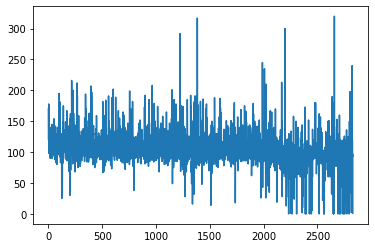

In [9]:
plt.plot(movies.runtime)

On choisit de ne retenir que les films d'une durée comprise entre 40 minutes et 4 heures.

In [10]:
cluster_features = cluster_features[cluster_features.runtime >= 40]
cluster_features = cluster_features[cluster_features.runtime <= 240]

On regarde la proportion de films pour lesquels certains champs n'ont pas été renseignés.

In [11]:
print("Nombre de films retenus dans cluster_features : ", len(cluster_features))
print("Parmi ces films :")
print(len(cluster_features[cluster_features.genres == "[]"]), "n'ont pas de genres")
print(len(cluster_features[cluster_features.keywords == "[]"]), "n'ont pas de keywords")
print(len(cluster_features[cluster_features.production_countries == "[]"]), "n'ont pas de production_countries")

Nombre de films retenus dans cluster_features :  2760
Parmi ces films :
20 n'ont pas de genres
262 n'ont pas de keywords
87 n'ont pas de production_countries


Il s'agit d'une petite proportion, on peut donc retirer ces films problématiques.

In [12]:
cluster_features = cluster_features[cluster_features.genres != "[]"]
cluster_features = cluster_features[cluster_features.keywords != "[]"]
cluster_features = cluster_features[cluster_features.production_countries != "[]"]
print("Nombre de films dans cluster_features : ", len(cluster_features))

Nombre de films dans cluster_features :  2456


On peut maintenant se concentrer sur le traitement des données de chacune des colonnes. Il faut les simplifier au maximum pour rendre possible la comparaison de films basée sur ces attributs.

In [13]:
def vectorize_genres(genres):
    
    if isinstance(genres, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(genres)])
    
    return genres

cluster_features.genres = cluster_features.genres.apply(vectorize_genres)

In [14]:
def vectorize_keywords(keywords):
    
    if isinstance(keywords, str):
        pattern = re.compile(r"'id': [0-9]*")
        return np.array([int(w[6:]) for w in pattern.findall(keywords)])
    
    return keywords

cluster_features.keywords = cluster_features.keywords.apply(vectorize_keywords)

In [15]:
def simplify_date(date):
    
    if isinstance(date, str):
        return int(date[:4])
    
    return date

cluster_features.release_date = cluster_features.release_date.apply(simplify_date)

In [16]:
def simplify_countries(countries):
    
    if isinstance(countries, str):
        pattern = re.compile(r"'iso_3166_1': ...")
        return [w[15:] for w in pattern.findall(countries)]
    
    return genres

cluster_features.production_countries = cluster_features.production_countries.apply(simplify_countries)

In [17]:
cluster_features.head()

,movieId,genres,keywords,release_date,production_countries,original_language,runtime
0,949,"[28, 80, 18, 53]","[642, 703, 974, 1523, 3713, 7281, 9727, 9812, ...",1995,[US],en,170.0
1,710,"[12, 28, 53]","[701, 769, 1308, 2812, 3268, 3272, 3278, 3376,...",1995,"[GB, US]",en,130.0
2,1408,"[28, 12]","[911, 1454, 1969, 3799, 5470, 12988]",1995,"[FR, DE, IT, US]",en,119.0
3,524,"[18, 80]","[383, 726, 1228, 2635, 33625]",1995,"[FR, US]",en,178.0
4,4584,"[18, 10749]","[420, 818, 964, 2755, 7564, 10911, 11109, 1506...",1995,"[GB, US]",en,136.0


In [18]:
cluster_features.tail()

,movieId,genres,keywords,release_date,production_countries,original_language,runtime
2819,2286,"[12, 14, 36]","[2868, 2901, 4379, 4820, 41406]",2006,"[NL, BE, DE, LU]",en,125.0
2821,26147,"[35, 10749]","[6075, 10556, 13042]",2005,[FI],fi,107.0
2823,2331,"[36, 18]","[186, 2292, 2974, 3034, 3036, 3902, 6506, 1100...",1999,"[CZ, DE, IT, US]",en,240.0
2826,3104,"[27, 878]","[6737, 155730]",1967,[GB],en,92.0
2827,64197,"[10749, 18]",[187056],2007,[RU],ru,97.0


### Définition d'une distance sur les films

In [19]:
MAX_YEAR_DIFFERENCE = max(cluster_features.release_date) - min(cluster_features.release_date)
MAX_RUNTIME_DIFFERENCE = max(cluster_features.runtime) - min(cluster_features.runtime)

Cette fonction calcule les similarités entre 2 films. Plus les valeurs sont proches de 0, plus les films ont de points communs et plus elles sont proches de 1, plus ils sont différents (peut-être changer le nom ? instinctivement, j'aurais pensé que pour être très similaire il fallait un score élevé REPONSE : il s'agit d'une distance)

discuter de la manière de les calculer ?

In [20]:
def similarity_vect(mov1, mov2):
    
    m1 = mov1.iloc[0] #
    m2 = mov2.iloc[0] # Passage de DataFrame en Series
    simi_vect = pd.Series([])
    
    # SIMILARITIES IN GENRES
    gen = np.append(m1.genres, m2.genres)
    simi_vect['genres'] = 2 * len(np.unique(gen)) / len(gen) - 1 # CHANGER PEUT ETRE
        
    # SIMILARITIES IN KEYWORDS
    kw = np.append(m1.keywords, m2.keywords)
    simi_vect['keywords'] = 2 * len(np.unique(kw)) / len(kw) - 1 # CHANGER PEUT ETRE
        
    #SIMILARITIES FOR THE RELEASE DATE
    simi_vect['release_date'] = abs(m1.release_date - m2.release_date) / MAX_YEAR_DIFFERENCE
    
    #SIMILARITIES IN PRODUCTION COUNTRIES
    pc = []
    pc.extend(m1.production_countries)
    pc.extend(m2.production_countries)
    simi_vect['production_countries'] = 2 * len(np.unique(pc)) / len(pc) - 1 # Changer aussi peut etre
    
    #SIMILARITIES FOR THE LANGUAGE
    simi_vect['original_language'] = int(not m1.original_language == m2.original_language)
    
    #SIMILARITIES FOR THE RUNTIME
    simi_vect['runtime'] = abs(m1.runtime - m2.runtime) / MAX_RUNTIME_DIFFERENCE
    
    return simi_vect

Cette fonction sert à donner des poids à chaque caractéristique.

In [21]:
def weight_vect(vect, w_gen=3, w_key=3, w_rel=2, w_pro=1, w_ori=1, w_run=2):
    
    vect.genres *= w_gen
    vect.keywords *= w_key
    vect.release_date *= w_rel
    vect.production_countries *= w_pro
    vect.original_language *= w_ori
    vect.runtime *= w_run
    
    return vect

In [22]:
def movie_distance(m1, m2, distance=lambda x: np.linalg.norm(x, ord=1)):
    simi_vect = similarity_vect(m1, m2)
    vect = weight_vect(simi_vect)
    return distance(vect)

La fonction compute_dist_matrix calcule la distance séparant chaque paire de films du DataFrame passé en argument. Cependant elle ne renvoit pas une matrice, mais un pd Series avec un double index (l'id de 2 films).

In [23]:
def compute_dist_matrix(clu_fea):
    dist = []
    movies_id = clu_fea.movieId.to_numpy() # Conversion de pd Series a np array
    couples = []
    for i in range(len(movies_id)):
        u = movies_id[i]
        for j in range(i + 1, len(movies_id)):
            v = movies_id[j]
            couples.append((str(u), str(v)))
            dist.append(movie_distance(clu_fea[clu_fea.movieId == u], clu_fea[clu_fea.movieId == v]))
    index = pd.MultiIndex.from_tuples(couples, names=['u', 'v'])
    dist_mat = pd.Series(dist, index=index)
    
    return dist_mat

On s'intéresse ici au Agglomerative Hierarchical Clustering. On n'a pas besoin de préciser le nombre de clusters attendus, à la place on obtient un dendrogramme.

In [24]:
class dendrogram:
    def __init__(self, leaf=None):
        self.leaf = leaf
        self.leaf_nb = 1
        self.father = None
        self.left = None
        self.right = None
    
    def set_leaf_nb(self):
        total_leaf_nb = 0
        if self.left is not None:
            total_leaf_nb += self.left.leaf_nb
        if self.right is not None:
            total_leaf_nb += self.right.leaf_nb
        self.leaf_nb = max(1, total_leaf_nb)
    
    def get_id_list(self):
        id_list = []
        def prefix(node):
            if node.leaf is not None:
                id_list.append(node.leaf)
            else:
                prefix(node.right)
                prefix(node.left)
        prefix(self)
        
        return id_list
    
    def get_root(self):
        tmp = self
        while tmp.father is not None: tmp = tmp.father
            
        return tmp

Fonction actualisant la moyenne des distances d'un cluster nouvellement formé, union des clusters x1 et x2. w1 et w2 sont respectivement la taille des clusters x1 et x2.

In [25]:
def weighted_mean(x1, w1, x2, w2):
    
    return (w1 * x1 + w2 * x2) / (w1 + w2)

On ajoute un attributs dendrogram aux films sélectionnés. Au départ, chaque film est isolé. Ensuite on construit le dendrogramme étape par étape en connectant les films les plus proches (on les regroupe dans un même cluster).

In [26]:
def clusterize(dist_mat, clu_fea):
    
    clu_fea["dendrogram"] = clu_fea.movieId.apply(lambda x: dendrogram(leaf=x))
    size_mat = clu_fea.shape[0]
    for cpt in range(1, size_mat):
        id_list = [tup[1] for tup in dist_mat.index[: size_mat - cpt]]
        id_list.append(dist_mat.index[0][0])
        index_str1, index_str2 = pd.Series.idxmin(dist_mat)
        index1, index2 = int(index_str1), int(index_str2)
        mov1 = clu_fea[clu_fea.movieId == index1].iloc[0]
        mov2 = clu_fea[clu_fea.movieId == index2].iloc[0]
        tmp1 = mov1.dendrogram
        tmp2 = mov2.dendrogram
        while tmp1.father is not None: tmp1 = tmp1.father
        while tmp2.father is not None: tmp2 = tmp2.father
        tmp3 = dendrogram()
        tmp3.left = tmp1
        tmp3.right = tmp2
        tmp3.set_leaf_nb()
        tmp1.father = tmp3
        tmp2.father = tmp3
        for x in id_list:
            if x == index_str1 or x == index_str2 : continue
            if (index_str1, x) in dist_mat.index:
                if (index_str2, x) in dist_mat:
                    tmp = weighted_mean(dist_mat.loc[index_str1, x], tmp1.leaf_nb,
                                        dist_mat.loc[index_str2, x], tmp2.leaf_nb)
                else:
                    tmp = weighted_mean(dist_mat.loc[index_str1, x], tmp1.leaf_nb,
                                        dist_mat.loc[x, index_str2], tmp2.leaf_nb)
                dist_mat.loc[index_str1, x] = tmp
            else:
                if (index_str2, x) in dist_mat:
                    tmp = weighted_mean(dist_mat.loc[x, index_str1], tmp1.leaf_nb,
                                        dist_mat.loc[index_str2, x], tmp2.leaf_nb)
                else:
                    tmp = weighted_mean(dist_mat.loc[x, index_str1], tmp1.leaf_nb,
                                        dist_mat.loc[x, index_str2], tmp2.leaf_nb)
                dist_mat.loc[x, index_str1] = tmp
        dist_mat = dist_mat.drop(index_str2, level='u')
        dist_mat = dist_mat.drop(index_str2, level='v')
    
    return clu_fea.iloc[0].dendrogram.get_root()

Test sur un échantillon de taille 10

In [27]:
test_10 = cluster_features.sample(10)
start_time = time.time()
dist_mat_test_10 = compute_dist_matrix(test_10)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 0.23340630531311035 secondes ---


In [28]:
start_time = time.time()
root_test_10 = clusterize(dist_mat_test_10, test_10)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 0.04687356948852539 secondes ---


Test sur un échantillon de taille 50

In [29]:
test_100 = cluster_features.sample(100)

In [30]:
start_time = time.time()
dist_mat_test_100 = compute_dist_matrix(test_100)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 22.623297691345215 secondes ---


In [31]:
start_time = time.time()
root_test_100 = clusterize(dist_mat_test_100, test_100)
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 1.528916597366333 secondes ---


In [32]:
start_time = time.time()
dist_mat = compute_dist_matrix(cluster_features) # environ ??? heures ?? minutes
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 35889.50049376488 secondes ---


In [33]:
start_time = time.time()
root = clusterize(dist_mat, cluster_features) # environ ??? heures ?? minutes
print("Temps d'execution : %s secondes ---" % (time.time() - start_time))

Temps d'execution : 8590.381591558456 secondes ---
